**Exploratory Analysis of Steam Data**

---

---

Initially getting all our Libraries required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from encodings.aliases import aliases

warnings.filterwarnings('ignore')

%matplotlib inline

Get Steam data from Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/29


Encoding and tokenization issues are cleared with this, most of the first data loading issues are encoding

In [3]:
import pandas as pd
import os
import csv
import sys

csv.field_size_limit(sys.maxsize)

#ISSUE 1) unknown format of encoding
  # I Increase field size limit to the system maximum

file_path = path + "/games.csv"

alias_values = set(aliases.values())

if not os.path.exists(file_path):
    print("Error: File not found! Check file path.")
else:
    for encoding in alias_values:
        if encoding.lower() == 'mbcs':  # Learned Google colab is using Mac,or Linux so mbbcs doesnt work
        #mbcs means Multi byte character set
            continue
        try:
            # Attempt to read the CSV file with better error handling
            df = pd.read_csv(
                file_path,
                encoding=encoding,
                engine='python'
            )
            print(f'Successful encoding: {encoding}')
            print(f'Dataframe shape: {df.shape}')
            break
        except pd.errors.ParserError as e:
            print(f"Parser error with encoding '{encoding}': {e}")
            continue
        except UnicodeDecodeError:
            print(f"Encoding error with '{encoding}'")
            continue
        except LookupError:
            print(f"Unsupported encoding: '{encoding}'")
            continue


Encoding error with 'euc_jis_2004'
Encoding error with 'euc_jisx0213'
Encoding error with 'gb2312'
Encoding error with 'cp1250'
Encoding error with 'kz1048'
Successful encoding: iso8859_2
Dataframe shape: (97410, 39)


Now i check for any edge cases like NaN,rows with missing values,

In [4]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

#isna() gives me NaN values and sum to make aggregation over all rows

# Display sample rows for validation
print("Sample data:")
print(df.head())

print('deleting Nans')
df = df.dropna() # Removes rows where 'Notes' is NaN


Missing values per column:
AppID                             6
Name                              0
Release date                      0
Estimated owners                  0
Peak CCU                          0
Required age                      0
Price                             0
DiscountDLC count                 0
About the game                 4870
Supported languages               0
Full audio languages              0
Reviews                       87285
Header image                      0
Website                       54673
Support url                   51510
Support email                 16035
Windows                           0
Mac                               0
Linux                             0
Metacritic score                  0
Metacritic url                93457
User score                        0
Positive                          0
Negative                          0
Score rank                    97366
Achievements                      0
Recommendations                   0
N

In [5]:
# Remove rows with incomplete data
df = df.dropna()
print(f"Dataframe shape after removing rows with missing values: {df.shape}")


Dataframe shape after removing rows with missing values: (0, 39)


In [6]:
# Clean corrupted text by replacing encoding errors
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: x.encode('utf-8', 'ignore').decode('utf-8') if isinstance(x, str) else x)

print("Data cleaned for encoding issues.")


Data cleaned for encoding issues.


In [7]:
import pandas as pd
import os

# File path
file_path = path + "/games.csv"  # Replace with actual CSV filename
output_file_path = path + "/games_cleaned.csv"  # Path to save the new UTF-8 encoded file

# Define the fallback encodings to attempt
fallback_encodings = ['windows-1252', 'latin1', 'mac_iceland']

# Check if file exists
if os.path.exists(file_path):
    for encoding in fallback_encodings:
        try:
            # Open the file with the specified encoding and replace errors
            with open(file_path, encoding=encoding, errors='replace') as f:
                # Read the CSV from the file object
                df = pd.read_csv(f)

            # Save the dataframe back in UTF-8 encoding
            df.to_csv(output_file_path, index=False, encoding='utf-8')
            print(f"Successfully read the file with encoding '{encoding}' and saved as UTF-8.")
            break
        except Exception as e:
            print(f"Error with encoding '{encoding}': {e}")
else:
    print("Error: File not found! Check file path.")

print(file_path)


Successfully read the file with encoding 'windows-1252' and saved as UTF-8.
/root/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/29/games.csv


Removing the duplicates if existed

In [8]:
df = df.drop_duplicates(inplace=True)


---

DATA ANALYSIS

Now that its cleaned ,im moving for analysis



In [9]:
df=pd.read_csv(path + "/games_cleaned.csv")

In [10]:
df.shape

(97410, 39)

Now those extra duplicates of 6 rows deleted

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97410 entries, 0 to 97409
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       97404 non-null  object 
 1   Name                        97410 non-null  object 
 2   Release date                97410 non-null  object 
 3   Estimated owners            97410 non-null  int64  
 4   Peak CCU                    97410 non-null  int64  
 5   Required age                97410 non-null  float64
 6   Price                       97410 non-null  int64  
 7   DiscountDLC count           97410 non-null  int64  
 8   About the game              92540 non-null  object 
 9   Supported languages         97410 non-null  object 
 10  Full audio languages        97410 non-null  object 
 11  Reviews                     10125 non-null  object 
 12  Header image                97410 non-null  object 
 13  Website                     427

Now you can only extract datetime from the column if the type is datetime,but above its an obj type so we convert to datetime

In [12]:


df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')

#why all the braces you ask
#there is a space at date in release date thats why

#Also there is an year 20000 which is way too future thats why coerce is used

Now we will check the non-numerics

In [13]:
df.describe()

,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,Metacritic score,User score,Positive,Negative,Score rank,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks
count,0,9.741000e+04,97410.000000,97410.000000,97410.0,97410.000000,97410.000000,97410.000000,9.741000e+04,97410.000000,44.000000,97410.000000,9.741000e+04,97410.000000,97410.000000,97410.000000,97410.000000
mean,NaT,1.627283e+02,0.282497,7.086262,0.0,0.493081,2.959193,0.034791,8.489366e+02,141.065989,98.909091,18.562622,6.905128e+02,91.797937,9.621271,81.852459,10.340417
min,NaT,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,NaT,0.000000e+00,0.000000,0.990000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,NaT,0.000000e+00,0.000000,4.190000,0.0,0.000000,0.000000,0.000000,5.000000e+00,1.000000,99.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,NaT,1.000000e+00,0.000000,9.990000,0.0,0.000000,0.000000,0.000000,3.500000e+01,10.000000,100.000000,17.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,NaT,1.284268e+06,21.000000,999.980000,0.0,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000
std,NaN,7.687116e+03,2.144294,12.387782,0.0,12.832834,14.545462,1.674105,2.287011e+04,4278.019743,0.857747,160.413540,1.681717e+04,1068.494928,177.190210,1412.496536,192.711603


In [14]:
#Some unique values

for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print()

Unique values in column 'AppID':
['Galactic Bowling' 'Train Bandit' 'Jolt Project' ...
 'Infiltrate & Extract' 'Escape The Garage' 'Lober Lobe']

Unique values in column 'Name':
['Oct 21, 2008' 'Oct 12, 2017' 'Nov 17, 2021' ... 'Aug 26, 2024'
 'Aug 25, 2024' 'Sep 2, 2024']

Unique values in column 'About the game':
['Galactic Bowling is an exaggerated and stylized bowling game with an intergalactic twist. Players will engage in fast-paced single and multi-player competition while being submerged in a unique new universe filled with over-the-top humor, wild characters, unique levels, and addictive game play. The title is aimed at players of all ages and skill sets. Through accessible and intuitive controls and game-play, Galactic Bowling allows you to jump right into the action. A single-player campaign and online play allow you to work your way up the ranks of the Galactic Bowling League! Whether you have hours to play or only a few minutes, Galactic Bowling is a fast paced and enterta

In [15]:
df.tail()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
97405,Femdom Game World: Mom,"Aug 22, 2024",NaT,0,0,4.19,0,0,. Femdom Game World - is a fascinating series ...,"['English', 'Russian']",...,0,0,0,Femdom Game World,Femdom Game World,"Single-player,Family Sharing",Casual,NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
97406,Blocky Farm,"Aug 30, 2024",NaT,0,0,8.99,0,0,Enter the charming world of Blocky Farm where ...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Forever Entertainment S. A.,Forever Entertainment S. A.,"Single-player,Steam Achievements,Partial Contr...","Casual,Simulation,Strategy",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
97407,Infiltrate & Extract,"Aug 30, 2024",NaT,0,0,0.00,0,0,Mission brief: You are deployed to a heavily g...,['English'],...,0,0,0,Carlos Garrido,DigiPen Intsitute of Technology,Single-player,"Strategy,Free To Play",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
97408,Escape The Garage,"Aug 29, 2024",NaT,0,0,4.99,0,0,"Welcome to Escape The Garage, the thrilling es...",['English'],...,0,0,0,CryneX,"CryneX,CryTechGames","Single-player,Steam Achievements,Family Sharing","Adventure,Casual,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
97409,Lober Lobe,"Aug 30, 2024",NaT,0,0,4.49,0,0,Scan Brain Lobes Organize &amp; clear dangerou...,['English'],...,0,0,0,James H. Van der Meulen,Trash Vomit Studios,"Single-player,Steam Achievements,Full controll...","Action,Casual,Indie",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


So we got to see the beginning and tail

Now, lets' see how age vs Pricing looks because we get to know what kind of age group are the gaming industries focusing on

In [16]:
df.describe()

,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,Metacritic score,User score,Positive,Negative,Score rank,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks
count,0,9.741000e+04,97410.000000,97410.000000,97410.0,97410.000000,97410.000000,97410.000000,9.741000e+04,97410.000000,44.000000,97410.000000,9.741000e+04,97410.000000,97410.000000,97410.000000,97410.000000
mean,NaT,1.627283e+02,0.282497,7.086262,0.0,0.493081,2.959193,0.034791,8.489366e+02,141.065989,98.909091,18.562622,6.905128e+02,91.797937,9.621271,81.852459,10.340417
min,NaT,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,NaT,0.000000e+00,0.000000,0.990000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,NaT,0.000000e+00,0.000000,4.190000,0.0,0.000000,0.000000,0.000000,5.000000e+00,1.000000,99.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,NaT,1.000000e+00,0.000000,9.990000,0.0,0.000000,0.000000,0.000000,3.500000e+01,10.000000,100.000000,17.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,NaT,1.284268e+06,21.000000,999.980000,0.0,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000
std,NaN,7.687116e+03,2.144294,12.387782,0.0,12.832834,14.545462,1.674105,2.287011e+04,4278.019743,0.857747,160.413540,1.681717e+04,1068.494928,177.190210,1412.496536,192.711603


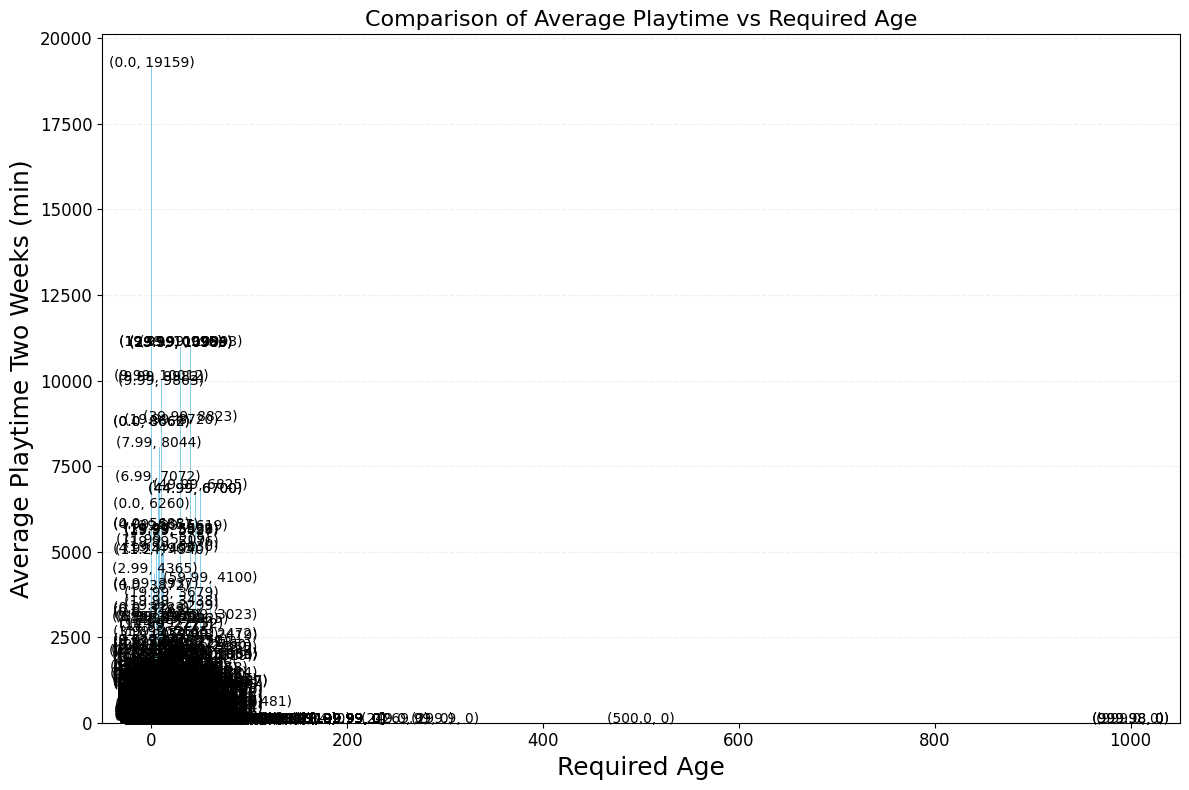

In [17]:
import matplotlib.pyplot as plt

# Assuming grouped_data has the following columns: "Required age" and "Average playtime two weeks"
# Example DataFrame for context:
# grouped_data = pd.DataFrame({"Required age": [3, 7, 12, 16], "Average playtime two weeks": [120, 90, 60, 30]})

plt.figure(figsize=(12, 8))  # Larger size for better visibility
plt.bar(df["Required age"], df["Average playtime two weeks"], color='skyblue')

# Add points (x, y) above each bar
for x, y in zip(df["Required age"], df["Average playtime two weeks"]):
    plt.text(x, y + 2, f"({x}, {y})", ha='center', fontsize=10, color='black')

plt.xlabel("Required Age", fontsize=18)
plt.ylabel("Average Playtime Two Weeks (min)", fontsize=18)
plt.title("Comparison of Average Playtime vs Required Age", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()  # Ensures everything fits in the figure
plt.show()


In [18]:
app_id_row = df[(df["Required age"] == 22.6) &
                          (df["Average playtime two weeks"] == 1002.0)]

# Extract the AppID
if not app_id_row.empty:
    app_id = app_id_row["Name"].values[0]  # Replace 'app_id' with the correct column name
    print(f"The AppID is: {app_id}")
else:
    print("No AppID found with the given values.")


The AppID is: Nov 22, 2021


Now we do some heatmpas and pie charts

THis si the pie chart for most replays

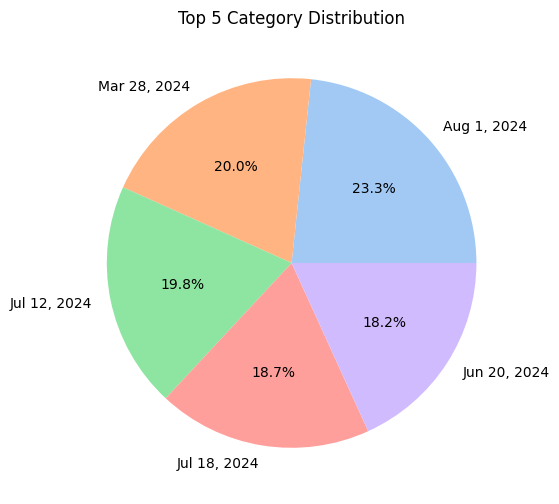

In [19]:
# Select a subset of categories by value count (only top 5 categories)
top_categories = df["Name"].value_counts().nlargest(5)

# Plot the pie chart for these top categories
plt.figure(figsize=(6, 6))
top_categories.plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Top 5 Category Distribution")
plt.ylabel("")  # Remove y-label for aesthetics
plt.show()


Now doing a heatmap for games ,most played

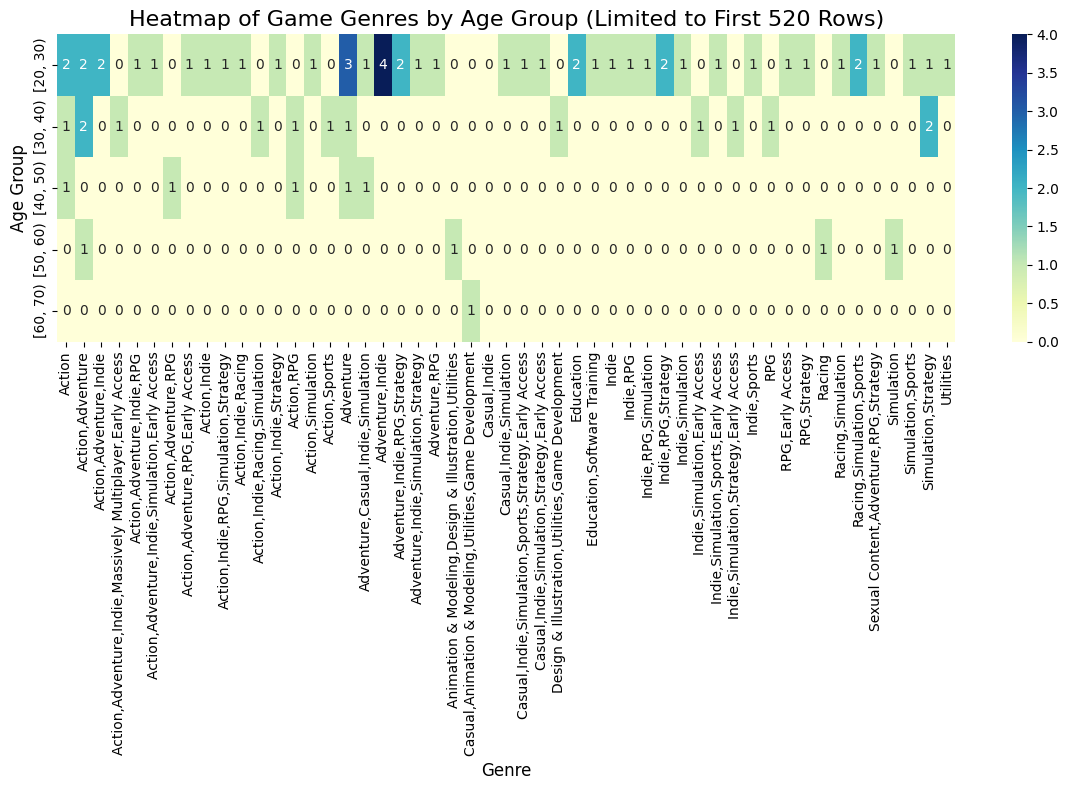

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Limit the data to the first 520 rows
limited_data = df.head(1520)

# Filter for age 20 and above
age_filtered_data = limited_data[limited_data["Required age"] >= 20]

# Create age bins (e.g., 20-30, 30-40, etc.)
age_bins = pd.cut(age_filtered_data["Required age"], bins=range(20, 80, 10), right=False)
age_filtered_data['Age Group'] = age_bins

# Create a pivot table for the heatmap: Rows = Age Groups, Columns = Genres
heatmap_data = age_filtered_data.pivot_table(index='Age Group', columns='Genres', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt="d", cbar=True)

# Adding labels and title
plt.title("Heatmap of Game Genres by Age Group (Limited to First 520 Rows)", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Age Group", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
